In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('LAB1 - Copy.txt', header=None)
data = df.to_numpy()

data1 = data[:,0]
data2 = data[:,1]
data3 = data[:,2]

In [3]:
def plotData(data, name):
    fig = plt.figure(figsize=(16, 9), dpi=100)
    plt.plot(range(len(data1)), data1, c='blue')
    plt.xlabel('Time')
    plt.ylabel(name)
    plt.title(f'Time series plot for {name}')
    plt.show()

In [4]:
def plt_pred(predictions, actual, name):
    predictions.plot(label='Prediction')
    actual.plot(label='Observed')
    plt.xlabel('Time')
    plt.ylabel(name)
    plt.title(f'Time series plot for {name}')
    plt.legend()
    plt.show()
    print(f"\nr2_score = {r2_score(actual, predictions)}")

# Stationarity

In [5]:
def tsplot(y, lags=None, figsize=(16, 20), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (3,1)
        ts_ax = plt.subplot2grid(layout, (0,0))
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (2,0))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [6]:
def optimize_SARIMA(data, parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [7]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'CLOSE': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);

In [8]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

# Data 1

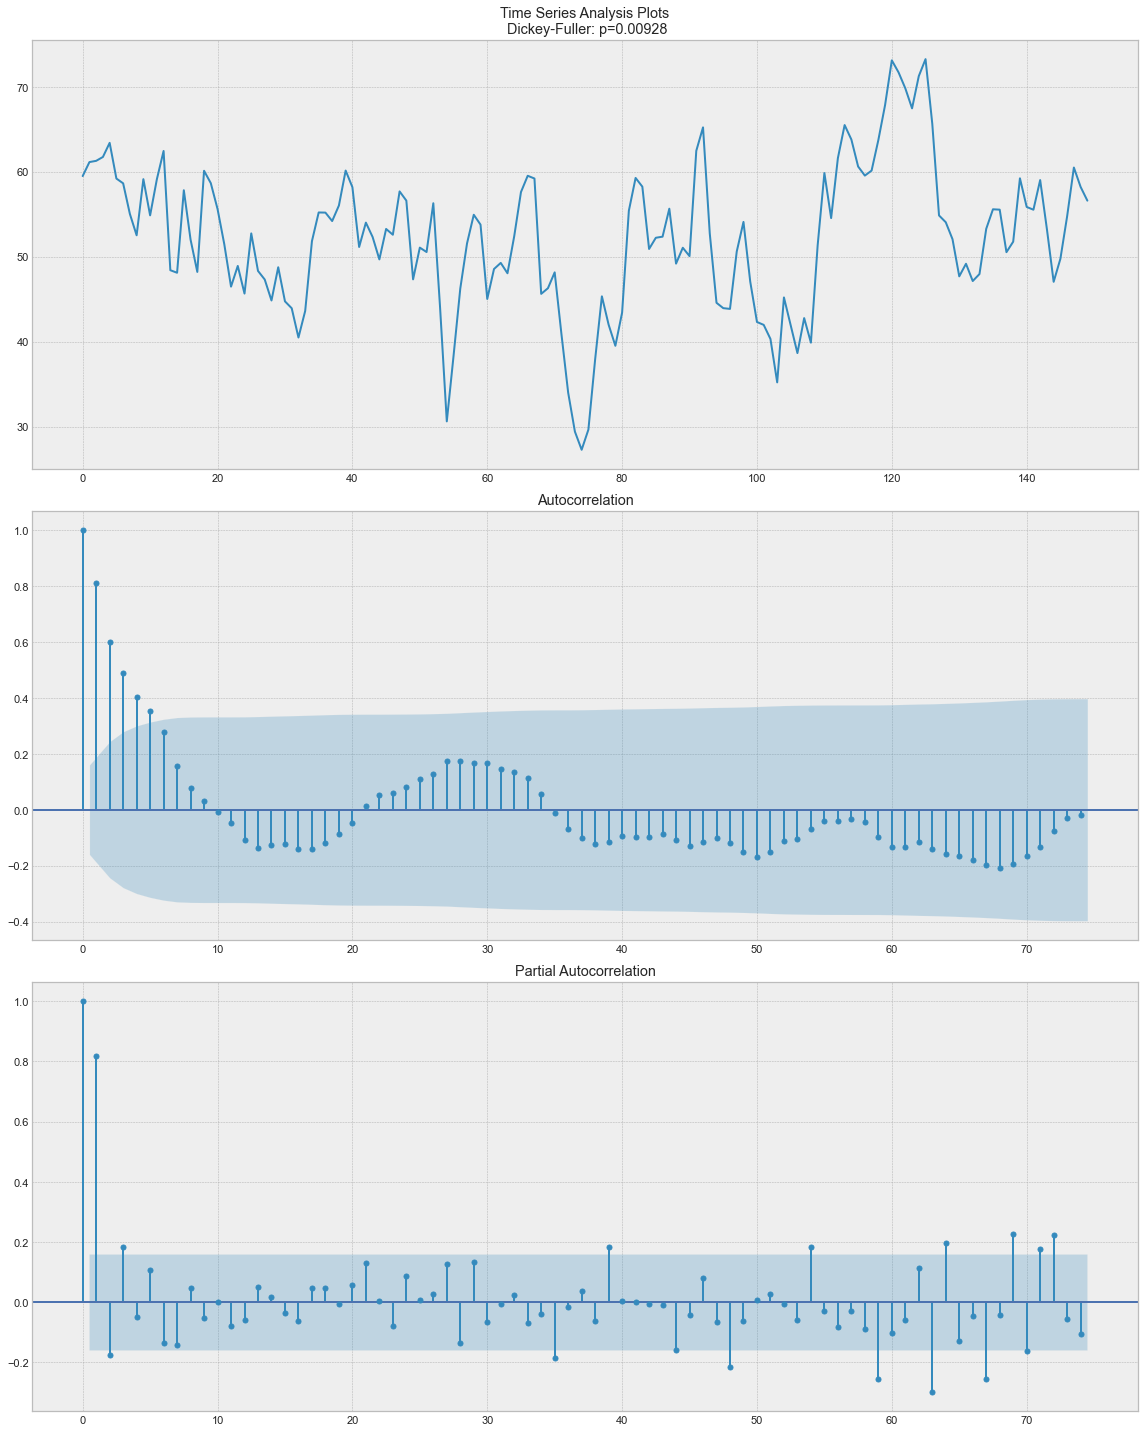

In [9]:
tsplot(df[0], lags=74)

### $H_0 =$ Dataset is not stationary.
### $H_A =$ Dataset is stationary.
### Dickey-Fuller stationarity Test p-value < 0.01. Reject $H_0$. 

In [10]:
result_table_d1 = optimize_SARIMA(df[0], parameters_list, d, D, s)

In [11]:
p, q, P, Q = result_table_d1.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df[0], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  150
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 5)   Log Likelihood                   0.000
Date:                             Wed, 05 May 2021   AIC                             12.000
Time:                                     17:57:29   BIC                             29.819
Sample:                                          0   HQIC                            19.241
                                             - 150                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       -1.09e-08   3.78e-05     -0.000      1.000    -7.4e-05     7.4e-05
ar.L2          1.0000   1.9

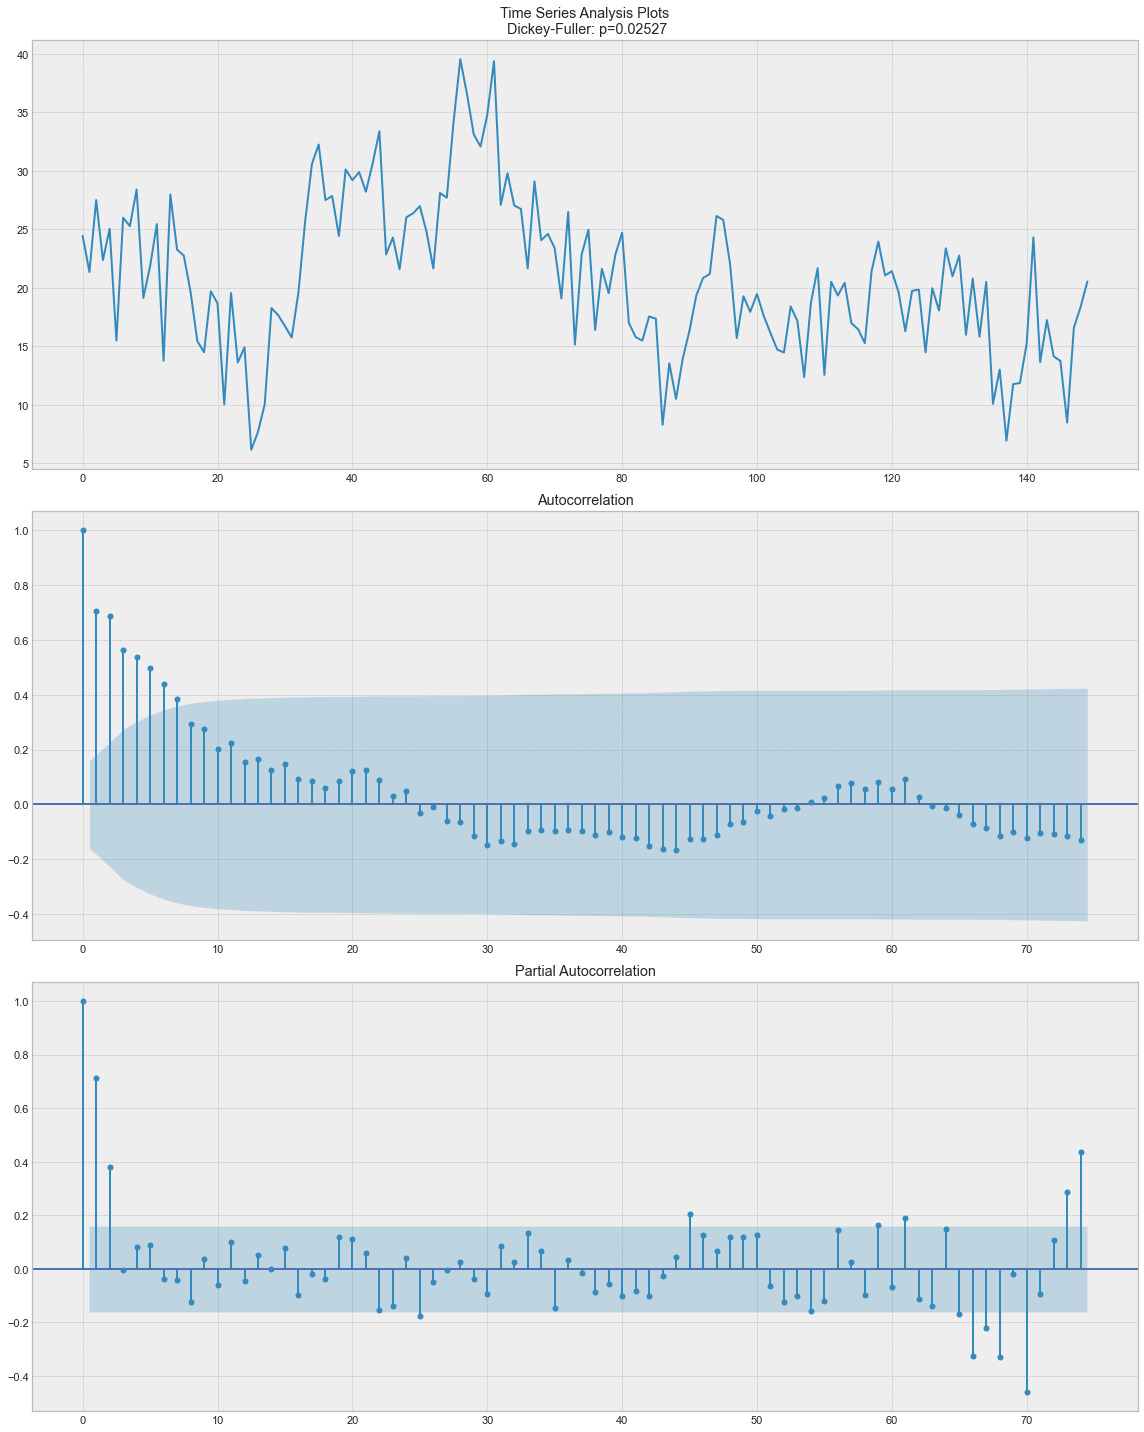

In [14]:
tsplot(df[1], lags=74)

In [15]:
result_table_d1 = optimize_SARIMA(df[1], parameters_list, d, D, s)

In [18]:
p, q, P, Q = result_table_d1.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df[1], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                         1   No. Observations:                  150
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2, 3], 5)   Log Likelihood                -420.367
Date:                                   Wed, 05 May 2021   AIC                            854.734
Time:                                           19:21:48   BIC                            875.523
Sample:                                                0   HQIC                           863.182
                                                   - 150                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5000      0.079     -6.302      0.000    

IndexError: invalid index to scalar variable.

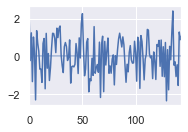

In [27]:
best_model.plot_diagnostics()

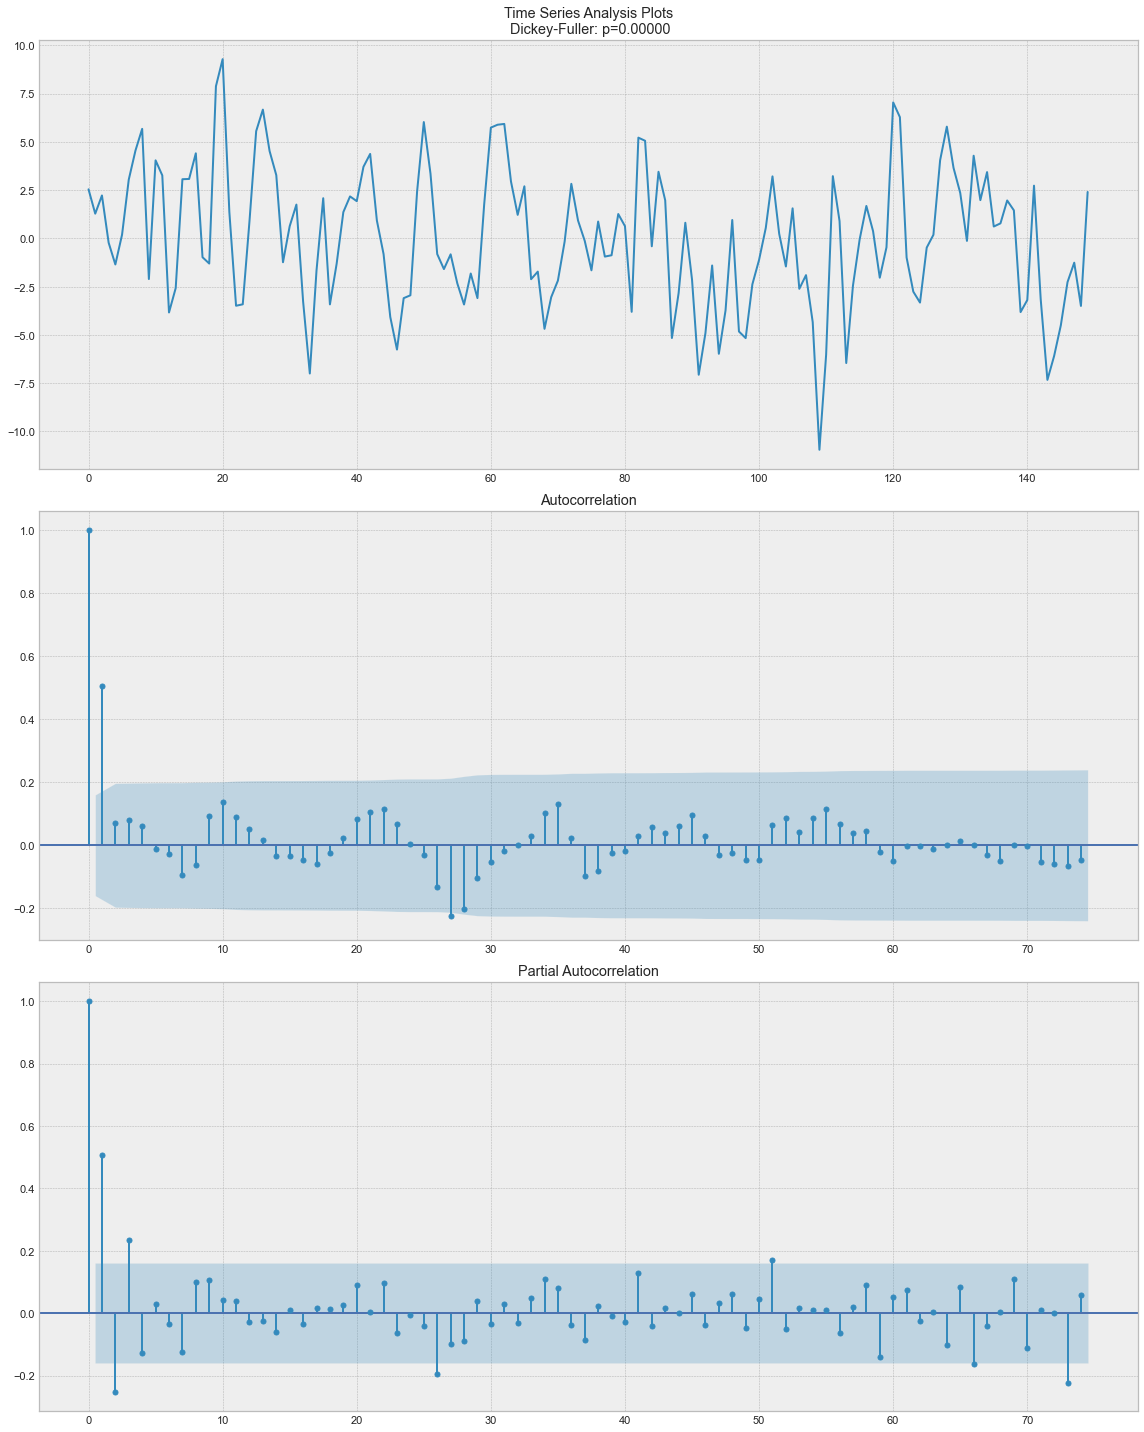

In [28]:
tsplot(df[2], lags=74)